In [1]:
import numpy as np
import scipy
from tqdm import trange
from tqdm.notebook import tqdm
import sys
import os

from matplotlib import pyplot as plt
import joblib
from joblib import Parallel, delayed, dump, load
from matplotlib import pyplot as plt
#import Sparse_vector
#sys.modules['sparse_vector'] = Sparse_vector
from Sparse_vector.sparse_vector import SparseVector


In [2]:
import torch
from torch.utils import data
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split, StratifiedKFold

In [3]:
chroms = [f'chr{i}' for i in list(range(1, 23)) + ['X', 'Y','M']]
all_features = [i[:-4] for i in os.listdir('z_dna/hg38_features/sparse/') if i.endswith('_2.pkl')]
groups = ['DNase-seq', 'Histone', 'RNA polymerase', 'TFs and others']
feature_names = [i for i in all_features]

def chrom_reader(chrom):
    files = sorted([i for i in os.listdir(f'z_dna/hg38_dna/') if f"{chrom}_" in i])
    return ''.join([load(f"z_dna/hg38_dna/{file}") for file in files])

In [4]:
from tqdm import tqdm
import sys
import time


In [5]:
%%time
DNA = {chrom:chrom_reader(chrom) for chrom in tqdm(chroms)}
# ZDNA_shin = load('z_dna/hg38_zdna/sparse/ZDNA_shin.pkl')
# ZDNA_cousine = load('z_dna/hg38_zdna/sparse/ZDNA_cousine.pkl')

ZDNA = load('z_dna/hg38_zdna/sparse/ZDNA_cousine.pkl')

DNA_features = {feature: load(f'z_dna/hg38_features/sparse/{feature}.pkl')
                for feature in tqdm(feature_names)}

100%|███████████████████████████████████████████████████████████████████████████████| 1946/1946 [00:52<00:00, 37.34it/s]

CPU times: user 51.8 s, sys: 4.52 s, total: 56.3 s
Wall time: 56 s


In [4]:
import numpy as np
from itertools import product

def generate_fix_n_subgroups(n):
    nucleotides = ['A', 'T', 'G', 'C']
    subgroups = []
    subgroups.extend([''.join(p) for p in product(nucleotides, repeat=n)])
    return subgroups

def generate_subgroups(n):
    nucleotides = ['A', 'T', 'G', 'C']
    subgroups = []
    for i in range(1, n + 1):
        subgroups.extend([''.join(p) for p in product(nucleotides, repeat=i)])
    return subgroups

def encode_sequence_as_features_ndarray(n_str: str, k_str: str):
    n = len(n_str)
    k = len(k_str)
    result = np.zeros(n, dtype=int)
    
    for i in range(n - k + 1):
        if n_str[i:i+k] == k_str:
            result[i:i+k] = 1
    
    return result.tolist()

In [11]:
from torch.utils import data

class Dataset(data.Dataset):
    def __init__(self, chroms, features,
                 dna_source, features_source,
                 labels_source, intervals, k_mer=1, groups=['A','T','G','C'],
                 lrp_feat=[]):
        self.chroms = chroms
        self.features = features
        self.dna_source = dna_source
        self.features_source = features_source
        self.labels_source = labels_source
        self.intervals = intervals
        
        self.k_mer = k_mer
        self.groups = groups
        
        self.lrp_feat = lrp_feat

    def __len__(self):
        return len(self.intervals)

    def __getitem__(self, index):
        interval = self.intervals[index]
        chrom = interval[0]
        begin = int(interval[1])
        end = int(interval[2])
        
        dna_OHE = []
        
        for group in self.groups:
            featuress = encode_sequence_as_features_ndarray(self.dna_source[chrom][begin:end].upper(), group)
            
            dna_OHE.append(featuress)
        
        dna_OHE = list(map(list, zip(*dna_OHE)))
        dna_OHE = np.array(dna_OHE)
        feature_matr = []
        
        if len(feature_matr) > 0:
            X = np.hstack((dna_OHE, np.array(feature_matr).T/1000)).astype(np.float32)
        else:
            X = dna_OHE.astype(np.float32)
            
        y = self.labels_source[interval[0]][interval[1]: interval[2]]
        if len(self.lrp_feat) > 0:
            X = X[:,np.sort(lrp_feat)]

        return (X, y)

In [7]:
width = 100


ints_in = []
ints_out = []

for chrm in chroms:
    for st in trange(0, ZDNA[chrm].shape - width, width):
        interval = [st, min(st + width, ZDNA[chrm].shape)]
        if ZDNA[chrm][interval[0]: interval[1]].any():
            ints_in.append([chrm, interval[0], interval[1]])
        else:
            ints_out.append([chrm, interval[0], interval[1]])

ints_in = np.array(ints_in)
ints_out = np.array(ints_out)[np.random.choice(range(len(ints_out)), size=len(ints_in) * 2, replace=False)]

100%|██████████████████████████████████████████████████████████████████████████████| 165/165 [00:00<00:00, 54075.65it/s]


In [8]:
from sklearn.model_selection import StratifiedShuffleSplit
np.random.seed(42)
equalized = np.vstack((ints_in, ints_out))
equalized = [[inter[0], int(inter[1]), int(inter[2])] for inter in equalized]

labels = np.array([1]*len(ints_in) + [0]*len(ints_out))
chromes = [inter[0] for inter in equalized]
strat_labels = np.array([f"{label}_{chrom}" for label, chrom in zip(labels, chromes)])
print(strat_labels)
  
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_inds, test_inds = next(sss.split(equalized, strat_labels))
  
train_intervals, test_intervals = [equalized[i] for i in train_inds], [equalized[i] for i in test_inds]

['1_chr1' '1_chr1' '1_chr1' ... '0_chr17' '0_chr14' '0_chr14']


In [12]:
params = {'batch_size':1,
          'num_workers':20,
          'shuffle':True}

max_k_mer_size = 4
groups = generate_subgroups(max_k_mer_size)
feature_count = len(groups)

train_dataset = Dataset(chroms, feature_names, 
                       DNA, DNA_features, 
                       ZDNA, train_intervals, max_k_mer_size, groups, lrp_feat = [])

test_dataset = Dataset(chroms, feature_names, 
                       DNA, DNA_features, 
                       ZDNA, test_intervals, max_k_mer_size, groups, lrp_feat = [])

loader_train = data.DataLoader(train_dataset, **params)
loader_test = data.DataLoader(test_dataset, **params)

# CNN Model

In [13]:
from torch import nn
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score, f1_score
from IPython.display import clear_output

class DeepCNNSiLU_9L(nn.Module):
    def __init__(self, top_count):
        super().__init__()
        
        self.num_f = top_count
        self.seq = nn.Sequential(
            
            nn.Conv2d(1, 3, kernel_size=(3, 3), padding=1),
            nn.LayerNorm([3, 100, top_count]),
            nn.SiLU(),
            
            nn.Conv2d(3, 5, kernel_size=(5, 5), padding=2),
            nn.LayerNorm([5, 100, top_count]),
            nn.SiLU(),
            
            nn.Conv2d(5, 7, kernel_size=(5, 5), padding=2),
            nn.LayerNorm([7, 100, top_count]),
            nn.SiLU(),
            
            nn.Conv2d(7, 9, kernel_size=(5, 5), padding=2),
            nn.LayerNorm([9, 100, top_count]),
            nn.SiLU(),
            
            nn.Conv2d(9, 9, kernel_size=(5, 5), padding=2),
            nn.SiLU(),
            
            nn.Conv2d(9, 7, kernel_size=(5, 5), padding=2),
            nn.LayerNorm([7, 100, top_count]),
            nn.SiLU(),
            
            nn.Conv2d(7, 5, kernel_size=(5, 5), padding=2),
            nn.LayerNorm([5, 100, top_count]),
            nn.SiLU(),
            
            nn.Conv2d(5, 3, kernel_size=(5, 5), padding=2),
            nn.LayerNorm([3, 100, top_count]),
            nn.SiLU(),
            
            nn.Conv2d(3, 1, kernel_size=(3, 3), padding=1),
            nn.LayerNorm([1, 100, top_count]),  # Укажите размеры после свертки
            nn.SiLU(),
            
            nn.Linear(top_count, 500),
            nn.SiLU(),
            
            nn.Linear(500, 2)
        )

    def forward(self, x):
        batch = x.shape[0]
        x = x.reshape(batch, 1, width, self.num_f)
        x = self.seq(x)
        x = torch.squeeze(x)
        x = F.log_softmax(x, dim=-1)
        return x

In [14]:
#torch.cuda.empty_cache()
device = torch.device('cuda:1')

In [15]:
model = DeepCNNSiLU_9L(feature_count)

model.load_state_dict(torch.load("DeepCNNSiLU_9L_1_4_k_mers.pt"))
model = model.to(device)
model.eval()

DeepCNNSiLU_9L(
  (seq): Sequential(
    (0): Conv2d(1, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LayerNorm((3, 100, 340), eps=1e-05, elementwise_affine=True)
    (2): SiLU()
    (3): Conv2d(3, 5, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): LayerNorm((5, 100, 340), eps=1e-05, elementwise_affine=True)
    (5): SiLU()
    (6): Conv2d(5, 7, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (7): LayerNorm((7, 100, 340), eps=1e-05, elementwise_affine=True)
    (8): SiLU()
    (9): Conv2d(7, 9, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (10): LayerNorm((9, 100, 340), eps=1e-05, elementwise_affine=True)
    (11): SiLU()
    (12): Conv2d(9, 9, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (13): SiLU()
    (14): Conv2d(9, 7, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (15): LayerNorm((7, 100, 340), eps=1e-05, elementwise_affine=True)
    (16): SiLU()
    (17): Conv2d(7, 5, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)

# Captum methods

In [16]:
import captum
from captum.attr import IntegratedGradients, GradientShap, LayerGradCam, LRP, InputXGradient, GuidedBackprop, Deconvolution, Saliency
from captum.attr import visualization as viz
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Integrated Gradients

In [21]:
mean_ig1 = np.zeros(feature_count, dtype=float)
cnt_ig = 0

for x, y_true in tqdm(loader_train):
    # make prediction
    x, y_true = x.to(device), y_true.to(device).long()
    output = model(x)
    pred = torch.argmax(output, dim=1).reshape(1, width)

    # find True Positive indices
    idxs = []
    for i in range(width):
        if pred[0][i] == y_true[0][i] and y_true[0][i] == 1:
            idxs.append(i)

    # IntegratedGradients
    #torch.cuda.empty_cache()
    integrated_gradients = IntegratedGradients(model).attribute(x, target=1, n_steps=1)
    integrated_gradients = torch.squeeze(integrated_gradients, dim=0)
    
    if integrated_gradients[idxs, :].shape != (0, feature_count):
        integrated_gradients = torch.mean(integrated_gradients[idxs, :], dim=0)
        integrated_gradients = np.array(integrated_gradients.cpu())
        #print(np.max(integrated_gradients))
        mean_ig1 += integrated_gradients
        cnt_ig += 1


# for test data
for x, y_true in tqdm(loader_test):
    # make prediction
    x, y_true = x.to(device), y_true.to(device).long()
    output = model(x)
    pred = torch.argmax(output, dim=1).reshape(1, width)

    # find True Positive indices
    idxs = []
    for i in range(width):
        if pred[0][i] == y_true[0][i] and y_true[0][i] == 1:
            idxs.append(i)

    # IntegratedGradients
    #torch.cuda.empty_cache()
    integrated_gradients = IntegratedGradients(model).attribute(x, target=1, n_steps=1)
    integrated_gradients = torch.squeeze(integrated_gradients, dim=0)
    
    if integrated_gradients[idxs, :].shape != (0, feature_count):
        integrated_gradients = torch.mean(integrated_gradients[idxs, :], dim=0)
        integrated_gradients = np.array(integrated_gradients.cpu())
        #print(np.max(integrated_gradients))
        mean_ig1 += integrated_gradients
        cnt_ig += 1

print('done IntegratedGradients interpretation')

100%|█████████████████████████████████████████████████████████████████████████████| 27121/27121 [09:17<00:00, 48.66it/s]

done IntegratedGradients interpretation


In [22]:
# mean for IntegratedGradients
mean_ig = mean_ig1 / cnt_ig
print(mean_ig)

[-1.73796627e+00 -1.66739516e+00  1.42893692e+01  1.28621315e+01
  1.63095089e-02 -2.20337430e-01 -2.05953194e-01 -2.95134500e-01
 -2.18851752e-03  2.04845183e-04  3.52068360e-03  6.08415587e-04
  5.57128619e-04  2.88344175e-03  1.32679393e-03  3.77820746e-03
  1.78605200e-03  7.55511588e-04  3.42599945e-03  1.23770675e-03
  3.97326163e-05  3.83489669e-05  1.02638181e-04  1.02842356e-04
  1.25511236e-04  3.68771267e-05  7.35137470e-04  8.26463296e-05
  1.29725531e-04  1.76240006e-04  4.31818816e-04  4.13024206e-04
  9.02929827e-04  1.33710742e-04  9.35564264e-04  2.90171077e-04
  2.28209206e-05  1.46792709e-04  5.41325077e-05  2.15731152e-04
  2.86046605e-05  7.61888589e-05  1.31743495e-04  1.01414604e-04
  1.87809546e-04  2.02572226e-03  5.25114161e-04  1.97007592e-03
  1.54147427e-04  2.00639107e-04  1.90360259e-04  3.07317725e-04
  8.47257670e-05  8.54756084e-05  4.22811885e-04  2.52736727e-04
  2.37495017e-04  1.56933119e-04  3.14253181e-03  3.29936626e-04
  2.99185001e-04  3.98125

In [23]:
np.save('DeepCNNSiLU_9L_1_4_k_mers_IG.npy', mean_ig)

In [21]:
np.load('DeepCNNSiLU_9L_IG.npy')

array([-1.03803493e+00,  7.24386997e+00,  6.93787200e+00, ...,
        3.67354698e-11,  1.91771597e-10,  5.47156208e-08])

# InputXGradient

In [24]:
mean_ixg1 = np.zeros(feature_count, dtype=float)
cnt_ixg = 0

for x, y_true in tqdm(loader_train):
    # make prediction
    x, y_true = x.to(device), y_true.to(device).long()
    output = model(x)
    pred = torch.argmax(output, dim=1).reshape(1, width)

    # find True Positive indices
    idxs = []
    for i in range(width):
        if pred[0][i] == y_true[0][i] and y_true[0][i] == 1:
            idxs.append(i)

    # InputXGradient
    inputx_gradients = InputXGradient(model).attribute(x, target=1)
    inputx_gradients = torch.squeeze(inputx_gradients, dim=0)
    
    if inputx_gradients[idxs, :].shape != (0, feature_count):
        inputx_gradients = torch.mean(inputx_gradients[idxs, :], dim=0)
        inputx_gradients = inputx_gradients.cpu().detach().numpy()
        #print(np.max(integrated_gradients))
        mean_ixg1 += inputx_gradients
        cnt_ixg += 1


# for test data
for x, y_true in tqdm(loader_test):
    # make prediction
    x, y_true = x.to(device), y_true.to(device).long()
    output = model(x)
    pred = torch.argmax(output, dim=1).reshape(1, width)

    # find True Positive indices
    idxs = []
    for i in range(width):
        if pred[0][i] == y_true[0][i] and y_true[0][i] == 1:
            idxs.append(i)

    # InputXGradient
    inputx_gradients = InputXGradient(model).attribute(x, target=1)
    inputx_gradients = torch.squeeze(inputx_gradients, dim=0)
    
    if inputx_gradients[idxs, :].shape != (0, feature_count):
        inputx_gradients = torch.mean(inputx_gradients[idxs, :], dim=0)
        inputx_gradients = inputx_gradients.cpu().detach().numpy()
        #print(np.max(integrated_gradients))
        mean_ixg1 += inputx_gradients
        cnt_ixg += 1

print('done InputXGradient interpretation')

100%|█████████████████████████████████████████████████████████████████████████████| 27121/27121 [08:30<00:00, 53.09it/s]

done InputXGradient interpretation


In [25]:
# mean for InputXGradient
mean_ixg = mean_ixg1 / cnt_ixg
print(mean_ixg)

[-1.68769566e+00 -1.75046616e+00  5.70187200e+00  6.81649054e+00
 -1.64617233e-02 -1.10226179e-01 -9.87538982e-02 -9.19971846e-02
 -4.40463930e-04  4.79881177e-04  5.35848525e-03  1.44683617e-03
  1.43696829e-03  4.38639365e-03  5.00907990e-03  1.26963840e-02
  4.32260905e-03  2.17191246e-03  1.09075775e-02  4.86412051e-03
  1.01914232e-04  7.79180463e-05  2.79487670e-04  2.09290973e-04
  1.22010346e-04  7.43793721e-05  9.43342778e-04  1.74944910e-04
  3.14941729e-04  3.69540372e-04  1.10186702e-03  1.24871867e-03
  1.39024016e-03  3.40599901e-04  2.09760546e-03  8.55984889e-04
  4.66886312e-05  1.48287885e-04  1.25715347e-04  2.94236183e-04
  5.63948126e-05  1.30410235e-04  2.89568600e-04  2.54001652e-04
  3.53337657e-04  2.30966797e-03  1.19531671e-03  3.77205864e-03
  3.03509958e-04  3.63644195e-04  5.46691665e-04  9.01192906e-04
  2.32725659e-04  1.82796354e-04  1.09652117e-03  6.33966252e-04
  3.23180254e-04  2.69260909e-04  4.62228542e-03  6.95738161e-04
  8.68799081e-04  9.96212

In [26]:
np.save('DeepCNNSiLU_9L_1_4_k_mers_IxG.npy', mean_ixg)

# saliency

In [27]:
mean_ixg1 = np.zeros(feature_count, dtype=float)
cnt_ixg = 0

for x, y_true in tqdm(loader_train):
    # make prediction
    x, y_true = x.to(device), y_true.to(device).long()
    output = model(x)
    pred = torch.argmax(output, dim=1).reshape(1, width)

    # find True Positive indices
    idxs = []
    for i in range(width):
        if pred[0][i] == y_true[0][i] and y_true[0][i] == 1:
            idxs.append(i)

    # InputXGradient
    inputx_gradients = Saliency(model).attribute(x, target=1)
    inputx_gradients = torch.squeeze(inputx_gradients, dim=0)
    
    if inputx_gradients[idxs, :].shape != (0, feature_count):
        inputx_gradients = torch.mean(inputx_gradients[idxs, :], dim=0)
        inputx_gradients = inputx_gradients.cpu().detach().numpy()
        #print(np.max(integrated_gradients))
        mean_ixg1 += inputx_gradients
        cnt_ixg += 1


# for test data
for x, y_true in tqdm(loader_test):
    # make prediction
    x, y_true = x.to(device), y_true.to(device).long()
    output = model(x)
    pred = torch.argmax(output, dim=1).reshape(1, width)

    # find True Positive indices
    idxs = []
    for i in range(width):
        if pred[0][i] == y_true[0][i] and y_true[0][i] == 1:
            idxs.append(i)

    # InputXGradient
    inputx_gradients = Saliency(model).attribute(x, target=1)
    inputx_gradients = torch.squeeze(inputx_gradients, dim=0)
    
    if inputx_gradients[idxs, :].shape != (0, feature_count):
        inputx_gradients = torch.mean(inputx_gradients[idxs, :], dim=0)
        inputx_gradients = inputx_gradients.cpu().detach().numpy()
        #print(np.max(integrated_gradients))
        mean_ixg1 += inputx_gradients
        cnt_ixg += 1

print('done InputXGradient interpretation')

100%|█████████████████████████████████████████████████████████████████████████████| 27121/27121 [08:31<00:00, 53.05it/s]

done InputXGradient interpretation


In [28]:
mean_ixg = mean_ixg1 / cnt_ixg
print(mean_ixg)

[3.24087214e+01 3.07620905e+01 3.29152697e+01 3.19892593e+01
 6.93770064e+00 2.29900758e+00 2.31344496e+00 6.45522327e-01
 5.02678334e-02 2.80726848e-02 2.87348904e-02 2.84914457e-02
 2.85499888e-02 2.92619013e-02 2.99236906e-02 3.03683111e-02
 2.94110758e-02 2.92928066e-02 2.99431951e-02 2.92033202e-02
 2.81045609e-02 2.75936934e-02 2.75147555e-02 2.75069463e-02
 2.75008058e-02 2.75383931e-02 2.76125511e-02 2.75731699e-02
 2.75773127e-02 2.76497207e-02 2.77542789e-02 2.77365014e-02
 2.76030482e-02 2.76143305e-02 2.77339879e-02 2.76657669e-02
 2.75446315e-02 2.74993799e-02 2.74977989e-02 2.75054355e-02
 2.74937392e-02 2.75070994e-02 2.75365171e-02 2.76243261e-02
 2.78488480e-02 2.82448781e-02 2.82866517e-02 2.83184316e-02
 2.78864049e-02 2.76917502e-02 2.76598572e-02 2.76760520e-02
 2.76185931e-02 2.76386332e-02 2.77407944e-02 2.76829169e-02
 2.77329598e-02 2.80399730e-02 2.85595722e-02 2.81751505e-02
 2.79613066e-02 2.80840985e-02 2.84940868e-02 2.86167043e-02
 2.85700603e-02 2.888149

In [29]:
np.save('DeepCNNSiLU_9L_1_4_k_mers_Saliency.npy', mean_ixg)

# LayerGradCam

In [30]:
mean_gcam1 = np.zeros(feature_count, dtype=float)
cnt_gcam = 0

for x, y_true in tqdm(loader_train):
    # make prediction
    x, y_true = x.to(device), y_true.to(device).long()
    output = model(x)
    pred = torch.argmax(output, dim=1).reshape(1, width)

    # find True Positive indices
    idxs = []
    for i in range(width):
        if pred[0][i] == y_true[0][i] and y_true[0][i] == 1:
            idxs.append(i)

    # GuidedGradCam
    
    layers = list(model.modules())[2:]
    #layers[5] = Conv2d(3, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

    #torch.cuda.empty_cache()
    grad_cam = LayerGradCam(model, layer=layers[5]).attribute(x, target=1)
    grad_cam = torch.squeeze(grad_cam, dim=0)
    grad_cam = torch.squeeze(grad_cam, dim=0)
    
    if grad_cam[idxs, :].shape != (0, feature_count):
        grad_cam = torch.mean(grad_cam[idxs, :], dim=0)
        grad_cam = grad_cam.cpu().detach().numpy()
        mean_gcam1 += grad_cam
        cnt_gcam += 1

for x, y_true in tqdm(loader_test):
    # make prediction
    x, y_true = x.to(device), y_true.to(device).long()
    output = model(x)
    pred = torch.argmax(output, dim=1).reshape(1, width)

    # find True Positive indices
    idxs = []
    for i in range(width):
        if pred[0][i] == y_true[0][i] and y_true[0][i] == 1:
            idxs.append(i)

    # GuidedGradCam
    
    layers = list(model.modules())[2:]
    #layers[5] = Conv2d(3, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

    #torch.cuda.empty_cache()
    grad_cam = LayerGradCam(model, layer=layers[5]).attribute(x, target=1)
    grad_cam = torch.squeeze(grad_cam, dim=0)
    grad_cam = torch.squeeze(grad_cam, dim=0)
    
    if grad_cam[idxs, :].shape != (0, feature_count):
        grad_cam = torch.mean(grad_cam[idxs, :], dim=0)
        grad_cam = grad_cam.cpu().detach().numpy()
        mean_gcam1 += grad_cam
        cnt_gcam += 1


print('done LayerGradCam interpretation')

100%|█████████████████████████████████████████████████████████████████████████████| 27121/27121 [08:27<00:00, 53.48it/s]

done LayerGradCam interpretation


In [31]:
# mean for LayerGradCam
mean_gcam = mean_gcam1 / cnt_gcam
print(mean_gcam.shape)
print(mean_gcam)

(340,)
[-1.72359138e-02 -3.18337055e-02 -5.08246593e-02 -2.80858927e-02
 -7.02694119e-03 -7.40603382e-03 -2.22295340e-03 -2.09616854e-04
 -1.84184605e-05 -1.43843031e-06 -1.54358674e-06 -1.58364625e-06
 -1.59272730e-06 -1.59290520e-06 -1.59287546e-06 -1.59286636e-06
 -1.59294893e-06 -1.59296499e-06 -1.59290585e-06 -1.59289747e-06
 -1.59296194e-06 -1.59295225e-06 -1.59297938e-06 -1.59297242e-06
 -1.59297228e-06 -1.59297537e-06 -1.59296651e-06 -1.59299024e-06
 -1.59297458e-06 -1.59296688e-06 -1.59301214e-06 -1.59303509e-06
 -1.59300779e-06 -1.59299900e-06 -1.59300531e-06 -1.59299586e-06
 -1.59300813e-06 -1.59299076e-06 -1.59297866e-06 -1.59296628e-06
 -1.59298114e-06 -1.59299537e-06 -1.59299386e-06 -1.59301702e-06
 -1.59299823e-06 -1.59298621e-06 -1.59297232e-06 -1.59297536e-06
 -1.59302414e-06 -1.59299549e-06 -1.59294755e-06 -1.59298023e-06
 -1.59299730e-06 -1.59297679e-06 -1.59296994e-06 -1.59297645e-06
 -1.59297158e-06 -1.59297114e-06 -1.59295890e-06 -1.59293408e-06
 -1.59289920e-06 -

In [32]:
np.save('DeepCNNSiLU_9L_1_4_k_mers_LayerGradCam.npy', mean_gcam)

# Агрегируем результаты интерпретации

## Переранжирование CNN

In [44]:
IxG = 'DeepCNNSiLU_9L_1_4_k_mers_IxG.npy'
IG = 'DeepCNNSiLU_9L_1_4_k_mers_IG.npy'
Saliency = 'DeepCNNSiLU_9L_1_4_k_mers_Saliency.npy'
LayerGradCam = 'DeepCNNSiLU_9L_1_4_k_mers_LayerGradCam.npy'

In [45]:
max_k_mer_size = 4
groups = generate_subgroups(max_k_mer_size)
feature_count = len(groups)
feature_count

340

In [46]:
import numpy as np
import pandas as pd
import os

file_list = [IxG, IG, Saliency, LayerGradCam]

data = {}

for file_name in file_list:
    
    arr = np.load(file_name)
    column_name = os.path.splitext(file_name)[0]

    data[column_name] = arr
    
df_cnn = pd.DataFrame(data)
df_cnn['feature'] =groups

In [47]:
df_cnn

,DeepCNNSiLU_9L_1_4_k_mers_IxG,DeepCNNSiLU_9L_1_4_k_mers_IG,DeepCNNSiLU_9L_1_4_k_mers_Saliency,DeepCNNSiLU_9L_1_4_k_mers_LayerGradCam,feature
0,-1.687696,-1.737966,32.408721,-1.723591e-02,A
1,-1.750466,-1.667395,30.762091,-3.183371e-02,T
2,5.701872,14.289369,32.915270,-5.082466e-02,G
3,6.816491,12.862132,31.989259,-2.808589e-02,C
4,-0.016462,0.016310,6.937701,-7.026941e-03,AA
...,...,...,...,...,...
335,0.002620,0.000635,0.028011,-1.593072e-06,CCGC
336,0.000683,0.000223,0.027843,-1.593049e-06,CCCA
337,0.000476,0.000143,0.027815,-1.592748e-06,CCCT
338,0.002207,0.000476,0.027926,-3.632894e-07,CCCG


In [48]:
p_deviation = pd.DataFrame() 


for column in df_cnn.columns:
    if column == 'feature':
        
        continue
    
    
    mean = df_cnn[column].mean()
    p_deviation[f'{column}_p_deviation'] = (((df_cnn[column] - mean) / mean) * 100) # считаем процентное среднее
    
p_deviation['mean_deviation'] = p_deviation.mean(axis=1)
p_deviation['feature'] = df_cnn['feature']

features_range = p_deviation.sort_values(by='mean_deviation', ascending=False)
features_range

,DeepCNNSiLU_9L_1_4_k_mers_IxG_p_deviation,DeepCNNSiLU_9L_1_4_k_mers_IG_p_deviation,DeepCNNSiLU_9L_1_4_k_mers_Saliency_p_deviation,DeepCNNSiLU_9L_1_4_k_mers_LayerGradCam_p_deviation,mean_deviation,feature
2,21389.017978,20893.828904,7385.768406,11785.652875,15363.567041,G
3,25589.753778,18796.942514,7175.170106,6468.055266,14507.480416,C
1,-6697.096306,-2549.723849,6896.080763,7344.503887,1248.441124,T
4,-162.040373,-76.038198,1477.809347,1543.292547,695.755831,AA
0,-6460.529048,-2653.406379,7270.566445,3930.722318,521.838334,A
...,...,...,...,...,...,...
100,-99.966899,-99.993487,-93.756063,-99.627471,-98.335980,ATAA
88,-99.967286,-99.992661,-93.756733,-99.627473,-98.336038,AATA
149,-99.971555,-99.993188,-93.756071,-99.627471,-98.337071,TAAT
104,-99.970884,-99.995497,-93.757034,-99.627469,-98.337721,ATTA


In [52]:
for i in list(features_range['feature'].head(10)):
    print(i)

G
C
T
AA
A
AT
AG
GC
CG
GCG


## Переранжирование GNN

In [53]:
GNN_explainer = 'GraphZSAGEConv_13L_1_5_k_mers_GNN_explainer.pt'
IxG = 'GraphZSAGEConv_13L_1_5_k_mers_IxG.pt'
IG = 'GraphZSAGEConv_13L_1_5_k_mers_IG.pt'
Saliency = 'GraphZSAGEConv_13L_1_5_k_mers_Saliency.pt'

In [54]:
max_k_mer_size = 5
groups = generate_subgroups(max_k_mer_size)
feature_count = len(groups)
feature_count

1364

In [55]:
import torch
import pandas as pd
import os

file_paths = [IxG, IG, Saliency, GNN_explainer]

data_dict = {}

for file_path in file_paths:
    tensor = torch.load(file_path)
    
    array = tensor.numpy()
    
    column_name = os.path.splitext(os.path.basename(file_path))[0] 
    data_dict[column_name] = array


df_gnn = pd.DataFrame(data_dict)
df_gnn['feature'] =groups

In [56]:
p_deviation = pd.DataFrame() 


for column in df_gnn.columns:
    if column == 'feature' or column == 'mean_GraphZSAGEConv_v5_lin_GNN_explainer':
        
        continue
    
    mean = df_gnn[column].mean()
    p_deviation[f'{column}_p_deviation'] = (((df_gnn[column] - mean) / mean) * 100) # считаем процентное среднее
    
p_deviation['mean_deviation'] = p_deviation.mean(axis=1)
p_deviation['feature'] = df_gnn['feature']

features_range = p_deviation.sort_values(by='mean_deviation', ascending=False)
features_range

,GraphZSAGEConv_13L_1_5_k_mers_IxG_p_deviation,GraphZSAGEConv_13L_1_5_k_mers_IG_p_deviation,GraphZSAGEConv_13L_1_5_k_mers_Saliency_p_deviation,GraphZSAGEConv_13L_1_5_k_mers_GNN_explainer_p_deviation,mean_deviation,feature
15,107359.269443,62008.644945,28.944675,3746.450265,43285.827332,GC
258,94944.633670,1414.782398,137.495549,711.889593,24302.200302,GGCG
1039,85902.293724,3110.467857,106.830118,566.727300,22421.579750,GGCGC
270,72748.534292,11967.900407,71.208175,677.633451,21366.319081,GCGG
335,68700.172017,2046.043975,173.586740,715.644396,17908.861782,CCGC
...,...,...,...,...,...,...
263,-83649.826886,-3545.687097,74.850907,826.124300,-21573.634694,GCAC
322,-98235.553845,9361.224223,47.691002,1649.897504,-21794.185279,CGCG
271,-128650.273736,-1341.847015,52.365359,1952.456973,-31996.824605,GCGC
1295,-160157.694705,-10432.690881,195.466216,1244.016336,-42287.725758,CGCGC


In [57]:
features_range.head(10)

,GraphZSAGEConv_13L_1_5_k_mers_IxG_p_deviation,GraphZSAGEConv_13L_1_5_k_mers_IG_p_deviation,GraphZSAGEConv_13L_1_5_k_mers_Saliency_p_deviation,GraphZSAGEConv_13L_1_5_k_mers_GNN_explainer_p_deviation,mean_deviation,feature
15,107359.269443,62008.644945,28.944675,3746.450265,43285.827332,GC
258,94944.633670,1414.782398,137.495549,711.889593,24302.200302,GGCG
1039,85902.293724,3110.467857,106.830118,566.727300,22421.579750,GGCGC
270,72748.534292,11967.900407,71.208175,677.633451,21366.319081,GCGG
335,68700.172017,2046.043975,173.586740,715.644396,17908.861782,CCGC
323,50594.963343,9794.545185,64.911536,754.120213,15302.135069,CGCC
78,55176.880983,2025.375931,82.414726,828.960827,14528.408117,CGG
47,48301.086939,8679.585898,5.133664,1065.681331,14512.871958,TGC
527,54797.939610,1035.201155,197.934641,122.340580,14038.353996,AGCGC
14,57114.629115,-2533.496199,41.843904,1343.711031,13991.671963,GG


In [58]:
for i in list(features_range['feature'].head(10)):
    print(i)

GC
GGCG
GGCGC
GCGG
CCGC
CGCC
CGG
TGC
AGCGC
GG


## Тепловая карта общая

In [17]:
res = pd.merge(df_cnn, df_gnn, on='feature', how='left')

In [18]:
res

,DeepCNNSiLU_9L_1_4_k_mers_IxG,DeepCNNSiLU_9L_1_4_k_mers_IG,DeepCNNSiLU_9L_1_4_k_mers_Saliency,DeepCNNSiLU_9L_1_4_k_mers_LayerGradCam,feature,GraphZSAGEConv_13L_1_5_k_mers_IxG,GraphZSAGEConv_13L_1_5_k_mers_IG,GraphZSAGEConv_13L_1_5_k_mers_Saliency,GraphZSAGEConv_13L_1_5_k_mers_GNN_explainer
0,-1.687696,-1.737966,32.408721,-1.723591e-02,A,-0.000014,0.001329,0.001480,0.055850
1,-1.750466,-1.667395,30.762091,-3.183371e-02,T,-0.000043,0.000778,0.001299,0.058642
2,5.701872,14.289369,32.915270,-5.082466e-02,G,-0.000266,0.002922,0.002374,0.182526
3,6.816491,12.862132,31.989259,-2.808589e-02,C,-0.000346,0.010012,0.003013,0.183997
4,-0.016462,0.016310,6.937701,-7.026941e-03,AA,-0.000004,0.000019,0.002746,0.005755
...,...,...,...,...,...,...,...,...,...
335,0.002620,0.000635,0.028011,-1.593072e-06,CCGC,-0.000435,-0.001607,0.007051,0.040782
336,0.000683,0.000223,0.027843,-1.593049e-06,CCCA,-0.000002,-0.000464,0.001793,0.010690
337,0.000476,0.000143,0.027815,-1.592748e-06,CCCT,-0.000027,-0.000362,0.003401,0.007440
338,0.002207,0.000476,0.027926,-3.632894e-07,CCCG,0.000176,0.000268,0.003753,0.033977


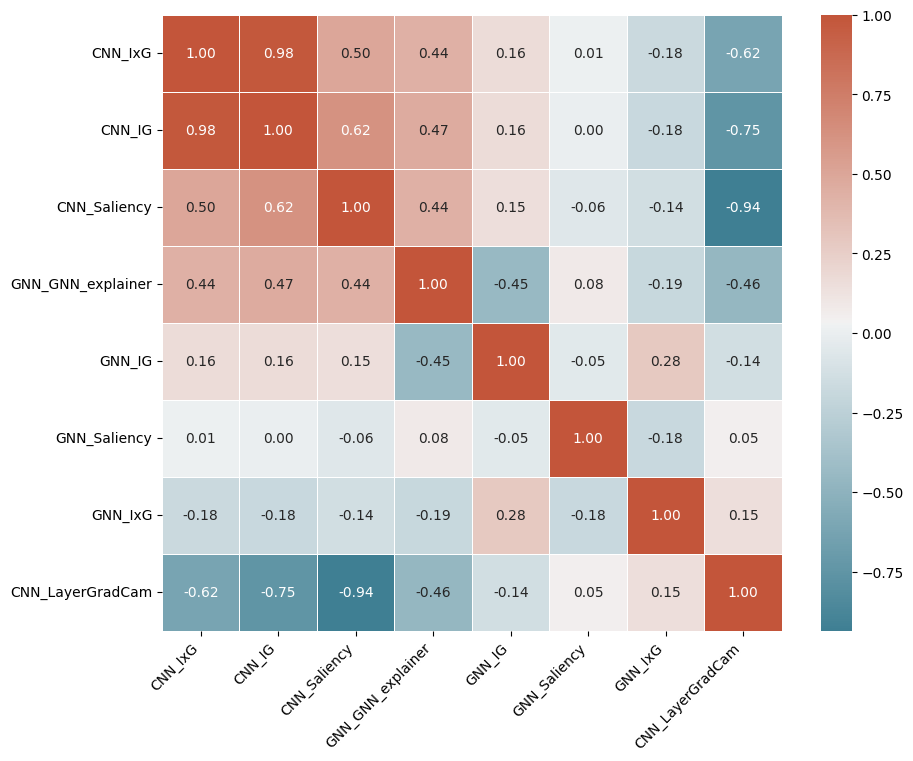

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

res.rename(columns=lambda x: x.replace('DeepCNNSiLU_9L_1_4_k_mers', 'CNN').replace('GraphZSAGEConv_13L_1_5_k_mers', 'GNN'), inplace=True)

corr_matrix = res[['CNN_IxG', 'CNN_IG', 'CNN_Saliency', 'GNN_GNN_explainer', 'GNN_IG', 'GNN_Saliency',
       'GNN_IxG',   'CNN_LayerGradCam',  ]].corr()

# Построение тепловой карты
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap=sns.diverging_palette(220, 20, as_cmap=True), linewidths=0.5)
plt.xticks(rotation=45, ha="right")  # ha="right" для выравнивания справа
plt.yticks(rotation=0)  # Подписи оси Y остаются горизонтальными

plt.show()

## Тепловая карта CNN

In [23]:
df_cnn.rename(columns=lambda x: x.replace('DeepCNNSiLU_9L_1_4_k_mers', 'CNN').replace('GraphZSAGEConv_13L_1_5_k_mers', 'GNN'), inplace=True)

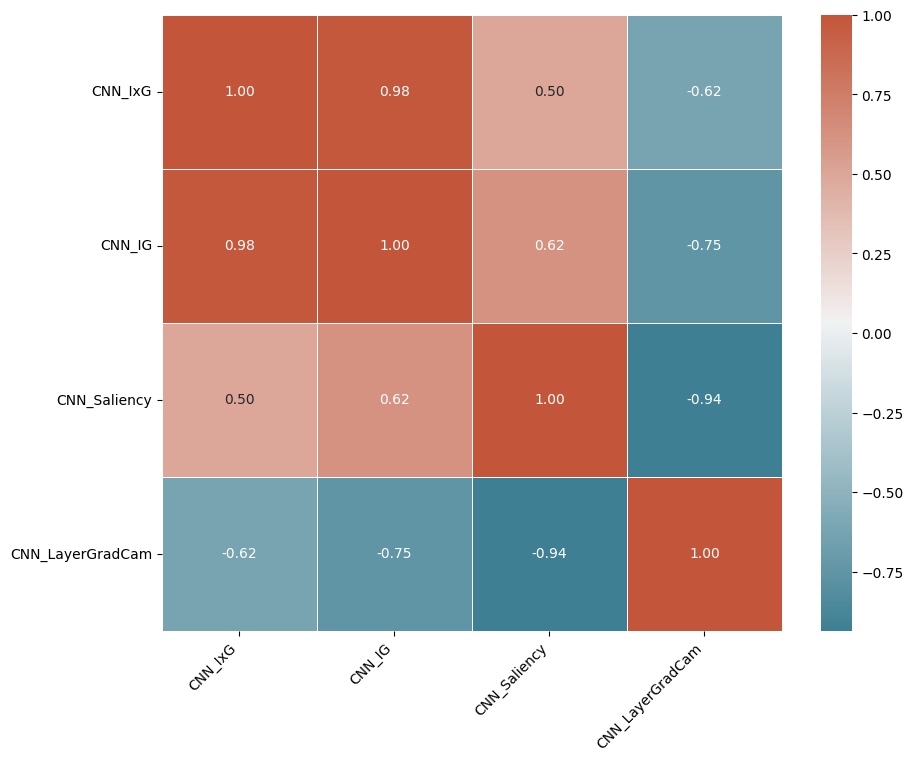

In [24]:
corr_matrix = df_cnn[['CNN_IxG', 'CNN_IG', 'CNN_Saliency', 
       'CNN_LayerGradCam', ]].corr()


# Построение тепловой карты
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap=sns.diverging_palette(220, 20, as_cmap=True), linewidths=0.5)
plt.xticks(rotation=45, ha="right")  # ha="right" для выравнивания справа
plt.yticks(rotation=0)  # Подписи оси Y остаются горизонтальными

plt.show()

## Тепловая карта GNN

In [25]:
df_gnn.rename(columns=lambda x: x.replace('DeepCNNSiLU_9L_1_4_k_mers', 'CNN').replace('GraphZSAGEConv_13L_1_5_k_mers', 'GNN'), inplace=True)

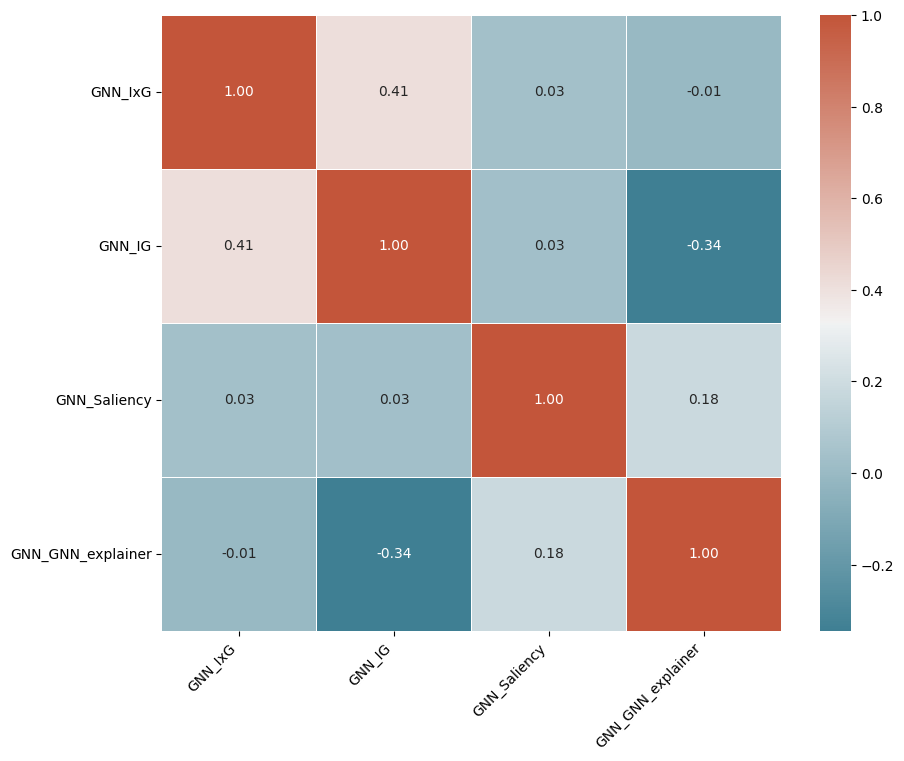

In [27]:
corr_matrix = df_gnn[[ 'GNN_IxG', 'GNN_IG', 'GNN_Saliency',  'GNN_GNN_explainer']].corr()


# Построение тепловой карты
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap=sns.diverging_palette(220, 20, as_cmap=True), linewidths=0.5)
plt.xticks(rotation=45, ha="right")  # ha="right" для выравнивания справа
plt.yticks(rotation=0)  # Подписи оси Y остаются горизонтальными

plt.show()

In [28]:
res.columns

Index(['CNN_IxG', 'CNN_IG', 'CNN_Saliency', 'CNN_LayerGradCam', 'feature',
       'GNN_IxG', 'GNN_IG', 'GNN_Saliency', 'GNN_GNN_explainer'],
      dtype='object')

In [34]:
a = list(res[['feature', 'CNN_IxG']].sort_values(by='CNN_IxG', ascending=False)['feature'])
b = list(res[['feature', 'CNN_IG']].sort_values(by='CNN_IG', ascending=False)['feature'])
c = list(res[['feature', 'CNN_Saliency']].sort_values(by='CNN_Saliency', ascending=False)['feature'])
d = list(res[['feature', 'CNN_LayerGradCam']].sort_values(by='CNN_LayerGradCam', ascending=False)['feature'])
e = list(res[['feature', 'GNN_IxG']].sort_values(by='GNN_IxG', ascending=False)['feature'])
f = list(res[['feature', 'GNN_IG']].sort_values(by='GNN_IG', ascending=False)['feature'])
g = list(res[['feature', 'GNN_Saliency']].sort_values(by='GNN_Saliency', ascending=False)['feature'])
h = list(res[['feature', 'GNN_GNN_explainer']].sort_values(by='GNN_GNN_explainer', ascending=False)['feature'])

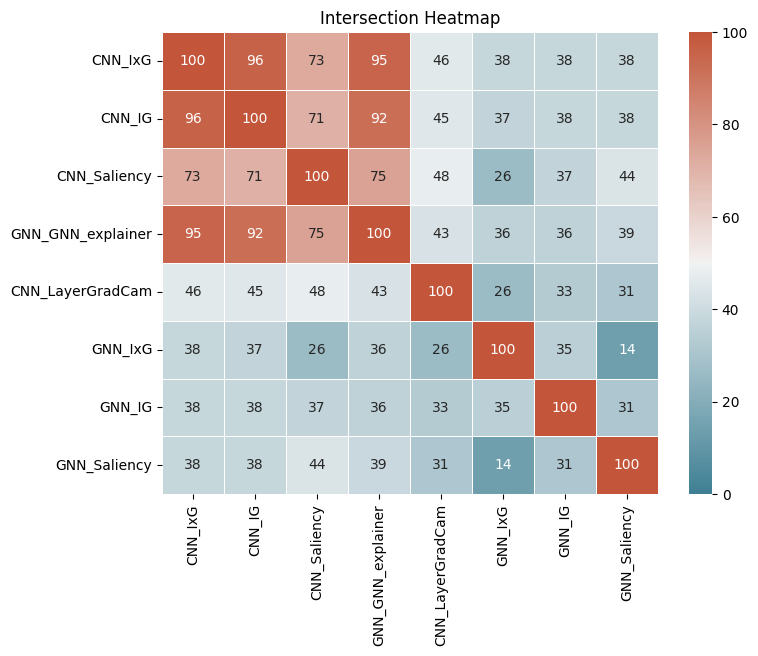

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

k= 100
# Создадим случайные списки для примера
list1 = set(a[:k])
list2 = set(b[:k])
list3 = set(c[:k])
list4 = set(d[:k])
list5 = set(e[:k])
list6 = set(f[:k])
list7 = set(g[:k])
list8 = set(h[:k])


lists = [list1, list2, list3, list8, list4, list5, list6, list7,  ]
list_names = ['CNN_IxG', 
              'CNN_IG',
              'CNN_Saliency',
              'GNN_GNN_explainer',
              'CNN_LayerGradCam', 
              'GNN_IxG',
              'GNN_IG',
              'GNN_Saliency',
              ]

# Подсчет количества пересечений
intersection_matrix = np.zeros((len(lists), len(lists)))

for i in range(len(lists)):
    for j in range(len(lists)):
        intersection_matrix[i, j] = len(lists[i] & lists[j])

# Преобразуем в DataFrame
df_intersection = pd.DataFrame(intersection_matrix, index=list_names, columns=list_names)

# Визуализация тепловой карты
plt.figure(figsize=(8, 6))
sns.heatmap(df_intersection, annot=True, fmt=".0f", cmap=sns.diverging_palette(220, 20, as_cmap=True), linewidths=0.5, vmin=0, vmax=100)
plt.title("Intersection Heatmap")
plt.show()

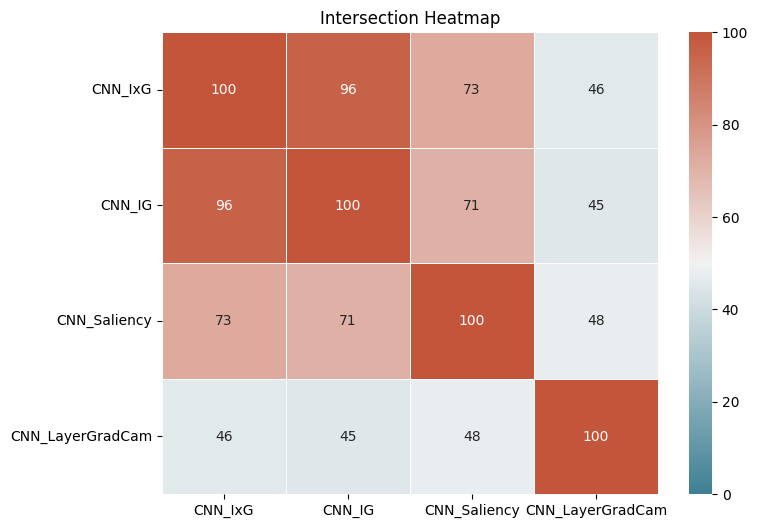

In [38]:
lists = [list1, list2, list3, list4]
list_names = ['CNN_IxG', 
              'CNN_IG',
              'CNN_Saliency',
              'CNN_LayerGradCam',
             ]

# Подсчет количества пересечений
intersection_matrix = np.zeros((len(lists), len(lists)))

for i in range(len(lists)):
    for j in range(len(lists)):
        intersection_matrix[i, j] = len(lists[i] & lists[j])

# Преобразуем в DataFrame
df_intersection = pd.DataFrame(intersection_matrix, index=list_names, columns=list_names)

# Визуализация тепловой карты
plt.figure(figsize=(8, 6))
sns.heatmap(df_intersection, annot=True, fmt=".0f", cmap=sns.diverging_palette(220, 20, as_cmap=True), linewidths=0.5, vmin=0, vmax=100)
plt.title("Intersection Heatmap")
plt.show()

In [39]:
df_gnn.columns

Index(['GNN_IxG', 'GNN_IG', 'GNN_Saliency', 'GNN_GNN_explainer', 'feature'], dtype='object')

In [41]:
e = list(df_gnn[['feature', 'GNN_IxG']].sort_values(by='GNN_IxG', ascending=False)['feature'])
f = list(df_gnn[['feature', 'GNN_IG']].sort_values(by='GNN_IG', ascending=False)['feature'])
g = list(df_gnn[['feature', 'GNN_Saliency']].sort_values(by='GNN_Saliency', ascending=False)['feature'])
h = list(df_gnn[['feature', 'GNN_GNN_explainer']].sort_values(by='GNN_GNN_explainer', ascending=False)['feature'])

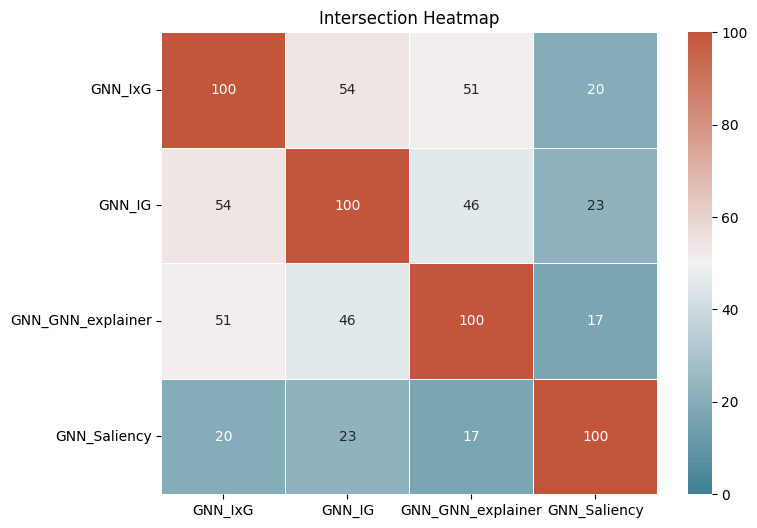

In [43]:
list5 = set(e[:k])
list6 = set(f[:k])
list7 = set(g[:k])
list8 = set(h[:k])

lists = [ list5, list6, list8, list7,  ]
list_names = ['GNN_IxG',
              'GNN_IG',
              'GNN_GNN_explainer', 
              'GNN_Saliency',
              
             ]

# Подсчет количества пересечений
intersection_matrix = np.zeros((len(lists), len(lists)))

for i in range(len(lists)):
    for j in range(len(lists)):
        intersection_matrix[i, j] = len(lists[i] & lists[j])

# Преобразуем в DataFrame
df_intersection = pd.DataFrame(intersection_matrix, index=list_names, columns=list_names)

# Визуализация тепловой карты
plt.figure(figsize=(8, 6))
sns.heatmap(df_intersection, annot=True, fmt=".0f", cmap=sns.diverging_palette(220, 20, as_cmap=True), linewidths=0.5, vmin=0, vmax=100)
plt.title("Intersection Heatmap")
plt.show()